# 3.1 Build models

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import cross_val_score
import os

def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

%matplotlib inline
sns.set_context('notebook')

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


//anaconda/envs/data_sci/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df = pd.read_csv(path+'/data/model_data/tci_final.csv',index_col=0)

In [3]:
df.shape

(113132, 59)

In [4]:
features = list(df.columns)
features.remove('vacant')

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[features], df['vacant'], test_size=0.2, random_state=42)

## Build the classifiers

### Random Forest Classifier

In [5]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=8, min_samples_split=3, \
                                 class_weight={0:1, 1:8}, \
                                 max_features=20, random_state=0, max_depth=40)
rfc = rfc.fit(X_train, y_train)
sound()

In [6]:
# pd.crosstab(y_test, rfc.predict(X_test),rownames=['From survey'],colnames=['From model'],margins=True)
pd.crosstab(y_test,rfc.predict(X_test),colnames=['predicted by RF'])

predicted by RF,0,1
vacant,,
0,19813,781
1,767,1266


In [7]:
dat = pd.DataFrame([rfc.predict_proba(X_test)[:,1], y_test, rfc.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G = {}
F = {}
G['res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'res': 0.77402133039418} {'res': 0.6205882352941177} 0.618466047874939 0.6227250368912937


In [8]:
# results = pd.DataFrame()
# for j in range(2,6):
#     rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=2*i, min_samples_split=3, \
#                                      class_weight={0:1, 1:8}, \
#                                      max_features=20, random_state=0, max_depth=40)
#     rfc = rfc.fit(X_train, y_train)
#     res = {}
#     for i in range(0,21):
#         # copy = y_test.copy()
#         p = i/20
#         copy = pd.Series(rfc.predict_proba(X_test)[:,1],index=y_test.index)
#         res[p] = {('correct_'+str(2*j)): sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#                   ('searched_'+str(2*j)): len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#                   ('percent_'+str(2*j)): sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
#     res = pd.DataFrame(res).T
#     results = pd.concat([results,res], axis=1)#, axis=1,keys=['a','b'])
# #     plt.plot(res.index, res.percent)
# sound()

In [9]:
res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(rfc.predict_proba(X_test)[:,1],index=y_test.index)
    res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
res = pd.DataFrame(res).T

# plt.plot(res.index, res.percent)

In [10]:
# from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
# from time import time
# from operator import itemgetter
# from scipy.stats import randint as sp_randint

# param_dist = {"max_depth": sp_randint(10, 50),
#               "max_features": sp_randint(5, 15),
#               "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# n_iter_search = 20
# random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
#                                    n_iter=n_iter_search)

# start = time()
# random_search.fit(train[features], y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))


In [11]:
# # Utility function to report best scores
# def report(grid_scores, n_top=3):
#     top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
#     for i, score in enumerate(top_scores):
#         print("Model with rank: {0}".format(i + 1))
#         print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#               score.mean_validation_score,
#               np.std(score.cv_validation_scores)))
#         print("Parameters: {0}".format(score.parameters))
#         print("")
# report(random_search.grid_scores_)

In [12]:
# tem = pd.DataFrame(rfc.predict_proba(test[features]))
# tem['vacant'] = test['vacant'].values
# tem = tem.sort_values(1, ascending=False)
# test.loc[:,'pred'] = rfc.predict(test[features])

In [13]:
# def fun(x):
#     if (x.pred == 1) & (x.vacant == 1):
#         return 'TP'
#     elif (x.pred == 1):
#         return 'FP'
#     elif (x.vacant == 1):
#         return 'FN'
#     else:
#         return 'TN'
# test.loc[:,'cat'] = test.apply(fun, axis=1)

In [14]:
# y2,_= pd.factorize(train.loc[train.index.isin(df[df.SPA_NAME.isin(west)].index)].vacant)

# rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, min_samples_split=2, \
#                                  class_weight={0:1, 1:1}, \
#                                  max_features=10, random_state=0, max_depth=20)
# rfc = rfc.fit(train.loc[train.index.isin(df[df.SPA_NAME.isin(west)].index),features], y2)
# sound()
# print(pd.crosstab(test[test.index.isin(df[df.SPA_NAME.isin(west)].index)].vacant, \
#                   rfc.predict(test.loc[test.index.isin(df[df.SPA_NAME.isin(west)].index),features])))

In [15]:
# west = ['Bellaire-Puritas','Brooklyn Centre','Clark-Fulton','Cudell','Detroit Shoreway','Edgewater'\
#        ,'Jefferson',"Kamm's",'Ohio City','Old Brooklyn','Stockyards','Tremont','West Boulevard']
# cols = ['GRAND_TOTAL_BALANCE','TAX_MARKET_LAND','sa_days','fc_days','c_ovv_2yr','pv_total',\
#         'tmktval','propsize','condition_value14','median_rent']

## Importances

Feature ranking:
1. feature 43, days_since_ovv (0.184009)
2. feature 44, c_ovv_num (0.092568)
3. feature 40, pv_count (0.087375)
4. feature 36, GRAND_TOTAL_PAID (0.078943)
5. feature 38, paid_percent (0.061390)
6. feature 50, fc_days (0.046402)
7. feature 51, sa_days (0.032933)
8. feature 37, delq_total_ratio (0.027937)
9. feature 32, TOTAL_NET_DELQ_BALANCE (0.025386)
10. feature 5, tmktval (0.018829)


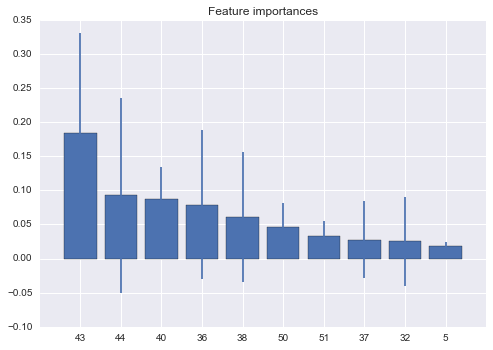

In [17]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Feature ranking (least important):
1. feature 46, c_ovv_board_num (0.000000)
2. feature 30, lb_acquired (0.000012)
3. feature 31, lb_tax_fc (0.000022)
4. feature 47, active_fc (0.000170)
5. feature 48, fc_1yr (0.000993)
6. feature 11, totbldgs (0.001008)
7. feature 1, occup (0.001721)
8. feature 0, cqual_num (0.002851)
9. feature 2, rnumstor (0.002881)
10. feature 24, asian (0.003369)


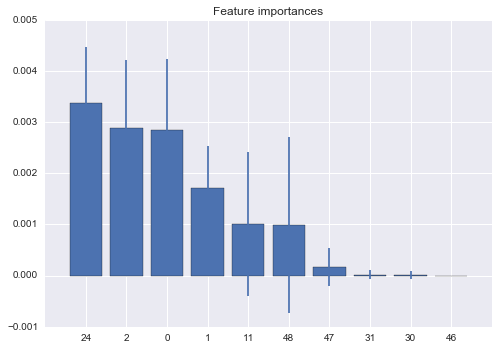

In [18]:
# Print the feature ranking
features2 = pd.DataFrame(features).iloc[indices[0:10]][0].values

print("Feature ranking (least important):")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

### Logistic Regressor

In [19]:
# features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant',\
#              'totusabl', 'tmktval', 'fc_days', 'days_since_transfer', 'propsize', 'yrbuilt_filtered', 'al_days']

# # features2 = ['c_O.V.V._2yr', 'pv_total','GRAND_TOTAL_BALANCE','condition_value','vacant']

In [21]:
# train_lr = preprocessing.scale(X_train)
# test_lr = preprocessing.scale(X_test)

# lr = LogisticRegression(class_weight={0:1, 1:2}, random_state=1001)
# lr.fit(pd.DataFrame(train_lr, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(test_lr))

In [22]:
lr = LogisticRegression(class_weight={0:1, 1:3}, random_state=1001)
lr.fit(pd.DataFrame(X_train, columns = features), y_train)
# pd.crosstab(y_test,lr.predict(X_test))

pd.crosstab(y_test,lr.predict(X_test),colnames=['predicted by LR'])

predicted by LR,0,1
vacant,,
0,19802,792
1,790,1243


In [23]:
dat = pd.DataFrame([lr.predict_proba(X_test)[:,1], y_test, lr.predict(X_test)]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['log_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['log_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'log_res': 0.7667451699976789, 'res': 0.77402133039418} {'log_res': 0.611111111111111, 'res': 0.6205882352941177} 0.6108108108108108 0.6114117068371864


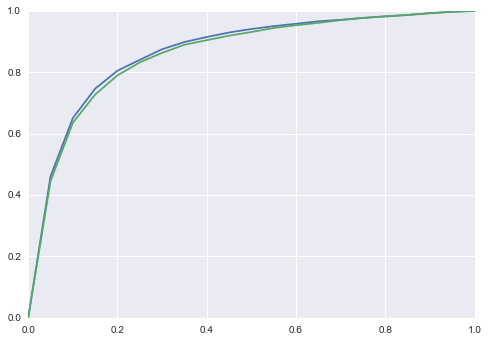

In [24]:
log_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(lr.predict_proba(X_test)[:,1],index=y_test.index)
    log_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
log_res = pd.DataFrame(log_res).T

plt.plot(res.index, res.percent)
plt.plot(log_res.index, log_res.percent)

In [25]:
importances = lr.coef_[0]
# std = np.std([tree.feature_importances_ for tree in lr.estimators_],
#              axis=0)
indices = np.argsort(abs(importances))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(15):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
print("\nFeature ranking (least important):")
for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))

Feature ranking:
1. feature 40, pv_count (0.213631)
2. feature 7, condition_value14 (-0.068455)
3. feature 42, v_total_2yr (0.067390)
4. feature 41, v_total_1yr (0.059442)
5. feature 6, condition_value13 (-0.058752)
6. feature 0, cqual_num (-0.023253)
7. feature 8, ownerocc_value (-0.018394)
8. feature 26, hispanic (-0.014316)
9. feature 37, delq_total_ratio (0.012757)
10. feature 10, LONGITUDE (0.011806)
11. feature 20, poverty_rate (0.011181)
12. feature 38, paid_percent (-0.009721)
13. feature 24, asian (-0.009694)
14. feature 1, occup (0.007235)
15. feature 23, black (0.006467)

Feature ranking (least important):
1. feature 46, c_ovv_board_num (0.000000)
2. feature 53, t_shf_deed (-0.000002)
3. feature 18, part_two_crimes (-0.000002)
4. feature 15, property_crimes (-0.000007)
5. feature 21, median_hh_income (0.000012)
6. feature 5, tmktval (-0.000012)
7. feature 39, GRAND_TOTAL_BALANCE_14 (0.000022)
8. feature 17, part_one_crimes (0.000024)
9. feature 3, propsize (-0.000026)
10. fe

### Gradient boosted classifier

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# est = GradientBoostingClassifier(n_estimators=300, learning_rate=0.7,
#     max_depth=1, random_state=0).fit(X_train, y_train)
# clf.score(train[features], y)                 

In [27]:
# from sklearn.ensemble import GradientBoostingClassifier

# est = GradientBoostingClassifier(n_estimators=500, learning_rate=0.7,
#     max_depth=1, random_state=0).fit(X_train, y_train)
# # clf.score(train[features], y)                 
# pd.crosstab(y_test, est.predict(X_test))

In [149]:
# dat = pd.DataFrame([est.predict_proba(X_test)[:,1], y_test, est.predict(X_test)]).T
# dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})

# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

In [28]:
# gbm_res = {}
# for i in range(0,21):
#     # copy = y_test.copy()
#     p = i/20
#     copy = pd.Series(est.predict_proba(X_test)[:,1],index=y_test.index)
#     gbm_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
# #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
# gbm_res = pd.DataFrame(gbm_res).T

# plt.plot(res.index, res.percent)
# plt.plot(log_res.index, log_res.percent)
# plt.plot(gbm_res.index, gbm_res.percent)
# plt.legend(['Random forest','Logistic regression','Gradient boosted trees'],loc='lower right');

In [29]:
# n_estimators = len(est.estimators_)

# def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6',
#                   test_color='#d7191c', alpha=1.0):
#     """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
#     test_dev = np.empty(n_estimators)

#     for i, pred in enumerate(est.staged_predict(X_test)):
#        test_dev[i] = est.loss_(y_test, pred)

#     if ax is None:
#         fig = plt.figure(figsize=(7, 5))
#         ax = plt.gca()

#     ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label,
#              linewidth=2, alpha=alpha)
#     ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color,
#              label='Train %s' % label, linewidth=2, alpha=alpha)
#     ax.set_ylabel('Error')
#     ax.set_xlabel('n_estimators')
# #     ax.set_ylim((0, 2))
#     return test_dev, ax

# test_dev, ax = deviance_plot(est, X_test, y_test)
# ax.legend(loc=[0.8,0.8])

# # add some annotations
# # ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',\
# #             xytext=(50, 1.0), textcoords='data',\
# #             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),\
# #             )

# ann = ax.annotate('', xy=(150, test_dev[149]),  xycoords='data',\
#                   xytext=(150, est.train_score_[149]), textcoords='data',\
#                   arrowprops=dict(arrowstyle="<->"))
# ax.text(160, 0.85, 'train-test gap')

In [30]:
# fig = plt.figure(figsize=(8, 5))
# ax = plt.gca()
# for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
#                                           ({'learning_rate': 0.1},
#                                            ('#fdae61', '#abd9e9'))]:
#     est = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
#     est.set_params(**params)
#     est.fit(X_train, y_train)

#     test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
#                                  train_color=train_color, test_color=test_color)

# ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
#             xytext=(300, 1.0), textcoords='data',
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
#             )
# ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
#             xytext=(600, 0.5), textcoords='data',
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
#             )
# plt.legend(loc='upper right')

In [31]:
# abc = AdaBoostClassifier(random_state=0)
# abc.fit(X_train, y_train)
# pd.crosstab(y_test, abc.predict(X_test), rownames=['actual'], colnames=['preds'])

In [32]:
# abc_res = {}
# for i in range(0,21):
#     # copy = y_test.copy()
#     p = i/20
#     copy = pd.Series(abc.predict_proba(X_test)[:,1],index=y_test.index)
#     abc_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
#               'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
# #     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
# abc_res = pd.DataFrame(abc_res).T

In [33]:
# sns.set_context('notebook')
# plt.plot(res.index, res.percent)
# plt.plot(log_res.index, log_res.percent)
# plt.plot(xgb_res.index, xgb_res.percent)
# plt.plot(abc_res.index, abc_res.percent)
# plt.plot([0,sum(y_test)/len(y_test)],[0,1],'k--',linewidth=1)
# plt.xlabel('Fraction of homes inspected')
# plt.ylabel('Fraction of vacant identified')
# # plt.set_xticklabels(fontsize='small')
# # plt.axis([-0.05,1.05,-0.05,1.05])
# plt.legend(['Random forest','Logistic regression','Gradient boosted trees','Perfect classifier'],loc='lower right');
# plt.savefig(path+'/outputs/model_inspection_comparison.ps')

### Single decision tree

In [81]:
from sklearn import tree

In [83]:
leafs = range(1,20,1)
scores = []
for leaf in leafs:
    clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
    scores.append(cross_val_score(clf, df[features], df.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');

KeyboardInterrupt: 

In [107]:
clf = tree.DecisionTreeClassifier(class_weight={0:1,1:2}, min_samples_leaf=12)
clf = clf.fit(X_train, y_train)

In [108]:
pd.crosstab(y_test, clf.predict(X_test), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,19649,945
1,865,1168


## xgboost

In [34]:
import xgboost as xgb

xgtest = X_test.as_matrix()
#create train and validation dmatrices 
xgtrain = X_train.as_matrix()

gbm = xgb.XGBClassifier(seed=0).fit(xgtrain, y_train)
predictions = gbm.predict(xgtest)
probs = gbm.predict_proba(xgtest)
pd.crosstab(y_test,predictions)

col_0,0,1
vacant,,
0,20351,243
1,1020,1013


In [56]:
pd.crosstab(y_test,pd.Series(probs[:,1]+.23).apply(lambda x: int(round(x))).values,rownames=['actual'],colnames=['predicted by GBM'])

predicted by GBM,0,1
actual,,
0,19930,664
1,766,1267


In [43]:
xgb_res = {}
for i in range(0,21):
    # copy = y_test.copy()
    p = i/20
    copy = pd.Series(probs[:,1]+.22)
#     copy = pd.Series(probs[:,1],index=y_test.index)
    xgb_res[p] = {'correct': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'searched': len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), \
              'percent': sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index])/sum(y_test) }
#     sum(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), len(y_test[copy.sort_values(ascending=False)[:int(len(X_test)*p)].index]), sum(y_test)
xgb_res = pd.DataFrame(xgb_res).T

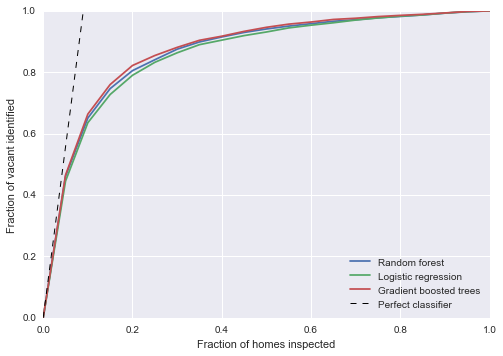

In [37]:
sns.set_context('notebook')
plt.plot(res.index, res.percent)
plt.plot(log_res.index, log_res.percent)
plt.plot(xgb_res.index, xgb_res.percent)
plt.plot([0,sum(y_test)/len(y_test)],[0,1],'k--',linewidth=1)
plt.xlabel('Fraction of homes inspected')
plt.ylabel('Fraction of vacant identified')
# plt.set_xticklabels(fontsize='small')
# plt.axis([-0.05,1.05,-0.05,1.05])
plt.legend(['Random forest','Logistic regression','Gradient boosted trees','Perfect classifier'],loc='lower right');
plt.savefig(path+'/outputs/model_inspection_comparison.ps')

In [38]:
tem = pd.concat([res[['correct']].iloc[range(0,22,2)], \
           log_res[['correct']].iloc[range(0,22,2)],\
           xgb_res[['correct']].iloc[range(0,22,2)] ], axis=1)

tem.columns = ['Random forest','Logistic regression','Gradient boosted']

tem

,Random forest,Logistic regression,Gradient boosted
0.0,0,0,0
0.1,1323,1292,1349
0.2,1637,1606,1671
0.3,1779,1755,1791
0.4,1860,1839,1865
0.5,1913,1893,1924
0.6,1948,1938,1959
0.7,1974,1972,1984
0.8,1996,1998,2003
0.9,2018,2018,2019


In [57]:
dat = pd.DataFrame([gbm.predict_proba(X_test)[:,1]+0.22, y_test, pd.Series(probs[:,1]+.23).apply(lambda x: int(round(x))).values]).T
dat = dat.rename(columns={0:'prob',1:'act',2:'pred'})


# sns.distplot(dat[(dat.act==1)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==1)].prob);
# sns.distplot(dat[(dat.act==1)&(dat.pred==0)].prob);
# sns.distplot(dat[(dat.act==0)&(dat.pred==0)].prob);
# plt.legend(['True vacant','False vacant','False Occupied','True Occupied'])

acc_neg = len(dat[(dat.act==0) & (dat.pred==0)])/len(dat[dat.act==0])
acc_pos = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.act==1])
G['xgb_res'] = (acc_neg*acc_pos)**0.5
prec = len(dat[(dat.act==1) & (dat.pred==1)])/len(dat[dat.pred==1])
F['xgb_res'] = 2*prec*acc_pos/(prec+acc_pos)
print(G, F, prec, acc_pos)

{'log_res': 0.7667451699976789, 'res': 0.77402133039418, 'xgb_res': 0.7766098834830125} {'log_res': 0.611111111111111, 'res': 0.6205882352941177, 'xgb_res': 0.6392532795156407} 0.6561367167270844 0.6232169208066897


In [58]:
G

{'log_res': 0.7667451699976789,
 'res': 0.77402133039418,
 'xgb_res': 0.7766098834830125}

In [59]:
F

{'log_res': 0.611111111111111,
 'res': 0.6205882352941177,
 'xgb_res': 0.6392532795156407}